## Writeup/README

The writeup / README should include a statement and supporting figures / images that explain how each rubric item was addressed, and specifically where in the code each step was handled.

## Camera Calibration

The camera calibration should be as easy as calling `camera.start_calibration(tiles_x, tiles_y, calibration_images_file_path, output_recorder)`. The `output_recorder` is an abstraction. It must have a `record_image(image)` method that will be called by the `start_calibration` method to record the image containing the drawn chess corners. With this abstraction, we can choose to record(display) the image in the screen or write it to a file.

Let's start with the packages imports:

In [54]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from enum import Enum
from collections import namedtuple
from abc import ABC, abstractmethod

import pickle
%matplotlib inline


### This is the abstraction class for recording the image output

In [56]:
class AbstractCalibrationImageOuputRecorder(ABC):
    
    @abstractmethod
    def initialize(self):
        pass
    
    @abstractmethod
    def record_image(index, cvimage):
        pass

### This class will record the output image to the screen using Pyplot:

In [57]:
class CalibrationImageOutputRecorderUsingPyplot(AbstractCalibrationImageOuputRecorder):
    
    def initialize(self):
        fig, axs = plt.subplots(5,4, figsize=(16, 11))
        fig.subplots_adjust(hspace = .2, wspace=.001)
        self.axs = axs.ravel()
            
    def record_image(self, index, cvimage):
        self.axs[index].axis('off')
        self.axs[index].imshow(cvimage.image_data)
        

### I am reusing my old `CvImage` class from the previous submission. This class encapsulate all the calls to OpenCV.

In [40]:
class LoadAs(Enum):
    Grayscale = 1
    ColorBGR = 2
    ColorRGB = 3
    ColorHSV = 4
    ColorHSL = 5
    
class CvImage:
    def __init__(self):
        self.load_as = None
        self.image_data = np.array([], dtype=np.int32)

    @staticmethod
    def create_black_image(width, height, channel_count = 3):
        image_data = np.zeros((height, width, channel_count), np.uint8)

        return CvImage.from_cv_image_data(image_data, LoadAs.ColorBGR)

    @staticmethod
    def load_from_file(filepath, load_as = LoadAs.ColorBGR):
        instance = CvImage()
        instance.load_as = load_as
        if load_as == LoadAs.Grayscale:
            instance.image_data = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        else:
            instance.image_data = cv2.imread(filepath)
            
        return instance
    
    @staticmethod
    def from_cv_image_data(cv_image_data, load_as = LoadAs.ColorBGR):
        
#         if cv_image_data.shape[0] == 0:
#             return None
        
        instance = CvImage()
        instance.load_as = load_as
        instance.image_data = cv_image_data
        
        return instance
    
    @staticmethod
    def load_from_image_data(cv_image_data, load_as = LoadAs.ColorBGR):
        return CvImage.from_cv_image_data(cv_image_data, load_as)

    def _get_intensity_m(self, brightness_value):
        intensitym = np.ones(self.image_data.shape, dtype="uint8") * brightness_value
        
        return intensitym
    
    def darken(self, darken_value):
        intensitym = self._get_intensity_m(darken_value)
        darkened_image_data = cv2.subtract(self.image_data, intensitym)
        
        return CvImage.load_from_image_data(darkened_image_data, self.load_as)
    
    def brighten(self, darken_value):
        intensitym = self._get_intensity_m(darken_value)
        darkened_image_data = cv2.add(self.image_data, intensitym)
        
        return CvImage.load_from_image_data(darkened_image_data, self.load_as)

    def height(self):
#         if self.image_data.shape[0] == 0:
#             return 0
        height, width = self.image_data.shape[:2]
        
        return height
    
    def width(self):
#         if self.image_data.shape[0] == 0:
#             return 0
        height, width = self.image_data.shape[:2]
        
        return width
        

    def channel_count(self):
#         if self.image_data.shape[0] == 0:
#             return 0
        return self.image_data.shape[2]
    
    def to_grayscale(self):
#         if self.image_data.shape[0] == 0:
#             return None        
        grayscale_image = cv2.cvtColor(self.image_data, cv2.COLOR_BGR2GRAY)
        
        return CvImage.from_cv_image_data(grayscale_image, LoadAs.Grayscale)
    

    def mask_and(self, other_image):
        result = cv2.bitwise_and(self.image_data, other_image.image_data)
        
        return CvImage.load_from_image_data(result, self.load_as)
    
    def mask_or(self, other_image):
        result = cv2.bitwise_or(self.image_data, other_image.image_data)
        
        return CvImage.load_from_image_data(result, self.load_as)

    def mask_xor(self, other_image):
        result = cv2.bitwise_xor(self.image_data, other_image.image_data)
        
        return CvImage.load_from_image_data(result, self.load_as)

    def mask_not(self):
        result = cv2.bitwise_not(self.image_data)
        
        return CvImage.load_from_image_data(result, self.load_as)
    
    def to_HSV(self):
        hsv = cv2.cvtColor(self.image_data, cv2.COLOR_RGB2HSV)
        
        return CvImage.load_from_image_data(hsv, LoadAs.ColorHSV)

    def to_HSL(self):
        hsv = cv2.cvtColor(self.image_data, cv2.COLOR_RGB2HLS)
        
        return CvImage.load_from_image_data(hsv, LoadAs.ColorHSL)
    
    def to_RGB(self):
        if self.load_as == LoadAs.Grayscale:
            rgb_image = cv2.cvtColor(self.image_data, cv2.COLOR_GRAY2RGB)
            
            return CvImage.load_from_image_data(rgb_image, LoadAs.ColorRGB)
        else:
            rgb_image = cv2.cvtColor(self.image_data, cv2.COLOR_BGR2RGB)

            return CvImage.load_from_image_data(rgb_image, LoadAs.ColorRGB)
    
    def gaussian_blur(self, kernel_size = 5):
        blurred = cv2.GaussianBlur(self.image_data, (kernel_size, kernel_size), 0)
        
        return CvImage.load_from_image_data(blurred, self.load_as);
    
    def threshold(self, black_threshold, other_color, ttype):
        ret, result = cv2.threshold(self.image_data, black_threshold, other_color, ttype)
        
        return CvImage.load_from_image_data(result, self.load_as)
    
    def threshold_binary(self, black_threshold, other_color):
        return self.threshold(black_threshold, other_color, cv2.THRESH_BINARY)
        
    def threshold_binary_inverse(self, black_threshold, other_color):
        return self.threshold(black_threshold, other_color, cv2.THRESH_BINARY_INV)

    def threshold_truncate(self, black_threshold, other_color):
        return self.threshold(black_threshold, other_color, cv2.THRESH_TRUNC)
    
    def threshold_to_zero(self, black_threshold, other_color):
        return self.threshold(black_threshold, other_color, cv2.THRESH_TOZERO)
    
    def canny(self, low_threshold = 50, high_threshold = 150, aperture_size = 3):
        cannied = cv2.Canny(self.image_data, low_threshold, high_threshold, aperture_size)
        
        return CvImage.load_from_image_data(cannied, self.load_as)    
        
                
    
    def filter_inrange(self, lower_value, upper_value):
        filtered = cv2.inRange(self.image_data, lower_value, upper_value)
        
        return CvImage.load_from_image_data(filtered, self.load_as)
    
    def find_chessboard_corners(self, corners_x, corners_y):
        ret, corners = cv2.findChessboardCorners(self.image_data, (corners_x, corners_y), None)
        
        if ret == True:
            return corners
        else:
            return []

    def draw_chessboard_corners_with_existing_corners(self, corners_x, corners_y, corners):
        if len(corners) > 0:
            copied_image = np.copy(self.image_data)
            cv2.drawChessboardCorners(copied_image, (corners_x, corners_y), corners, True)
        else:
            print("Failed top find chessboard corners")
            return self
        
        return CvImage.load_from_image_data(copied_image, self.load_as)
        
    def draw_chessboard_corners(self, corners_x, corners_y):
        gray = self.to_grayscale()
        corners = gray.find_chessboard_corners(corners_x, corners_y)

        # If found, draw corners
        if len(corners) > 0:
            # Draw and display the corners
            copied_image = np.copy(self.image_data)
            cv2.drawChessboardCorners(copied_image, (corners_x, corners_y), corners, True)
        else:
            print("Failed top find chessboard corners")
            return self
        
        return CvImage.load_from_image_data(copied_image, self.load_as)
    
    def undistort(self, camera_calibration_result):
        undistorted = cv2.undistort(self.image_data, camera_calibration_result.calibration_matrix, camera_calibration_result.calibration_distance, None, camera_calibration_result.new_camera_matrix)
        
        return CvImage.load_from_image_data(undistorted, self.load_as)
            
    def unwarp(self, src, dst):
        h,w = self.image_data.shape[:2]
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
        
        return CvImage.load_from_image_data(warped)
#         return warped, M, Minv

In [59]:
CameraCalibrationResult = namedtuple("CameraCalibrationResult", "calibration_matrix calibration_distance new_camera_matrix")

class Camera:
    def __init__(self):
        self.calibration_matrix = None
        self.calibration_distance = -1
        self.new_camera_matrix = None
        
    def start_calibration(self, tiles_x, tiles_y, calibration_images_file_path, output_recorder):
        objpoints = []
        imgpoints = []
        
        termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        objp = np.zeros((tiles_x * tiles_y, 3), np.float32)
        objp[:,:2] = np.mgrid[0:tiles_x,0:tiles_y].T.reshape(-1, 2)
        
        output_recorder.initialize()
        
        index = 0
        for calibration_image_file in calibration_image_files:            
            
            calibration_image = CvImage.load_from_file(calibration_image_file)
            gray =  calibration_image.to_grayscale()
            
            chessboard_corners = gray.find_chessboard_corners(tiles_x, tiles_y)
            if len(chessboard_corners) > 0:
                corners2 = cv2.cornerSubPix(gray.image_data,chessboard_corners,(11,11),(-1,-1), termination_criteria)
                                
                imgpoints.append(corners2)
                objpoints.append(objp)
                
                output_image = calibration_image.draw_chessboard_corners_with_existing_corners(tiles_x, tiles_y, chessboard_corners)
                output_recorder.record_image(index, output_image)
            else:
                print('Not found for index:' + str(index))
                
            index += 1
            
            
        if self.calibration_distance == -1:      
            calibration_image = CvImage.load_from_file(calibration_image_file)
            image_dimension = (calibration_image.image_data.shape[1], calibration_image.image_data.shape[0])
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_dimension, None, None)
            self.calibration_matrix = mtx
            self.calibration_distance = dist
            
        
        return CameraCalibrationResult(self.calibration_matrix, self.calibration_distance, self.calibration_matrix)        
        
    def find_correct_corners(self, calibration_image_files):
        index = 0
        corners_hash = {}
        for calibration_image_file in calibration_image_files:
            cvimage = CvImage.load_from_file(calibration_image_file)
            gray = cvimage.to_grayscale()
            corners_found = False
            for i in range(10, 2, -1):
                for j in range(7, 2, -1):
                    print('searching with x:' + str(i) + ', y:' + str(j) )
                    corners = gray.find_chessboard_corners(i, j)
                    if len(corners) > 0:
                        corners_hash[index] = (i, j)
                        corners_found = True
                        break
                if corners_found: 
                    break                
            index += 1
            
        return corners_hash
        
        

### I defined a `File` class to abstract the file system access:

In [60]:
import os

class File:
    @staticmethod
    def list_folder(folder_path):
        return os.listdir(folder_path)

### After we have all the required classes defined, now we can start the camera calibration

Previously, I tried to search for the best tiles size for each images but after several experiments. I stick with using `9x6` tiles. Below is the result of the tiles size I found for each images:

`corners_hash = {0: (7, 6), 1: (7, 4), 2: (9, 6), 3: (9, 6), 4: (9, 6), 5: (9, 6), 6: (9, 5), 7: (9, 6), 8: (9, 6), 9: (9, 6), 10: (9, 6), 11: (9, 6), 12: (9, 6), 13: (9, 6), 14: (9, 6), 15: (9, 6), 16: (9, 6), 17: (9, 6), 18: (9, 6), 19: (9, 6), 20:(8,6)}`


To calibrate the camera, we just need to instantiate a new instance of the `Camera` class. Then call the `start_calibration()` method and I passed an instance of `CalibrationImageOutputRecorderUsingPyplot` class because I want to output the output images to the screen.

Not found for index:0
Not found for index:1
Not found for index:6


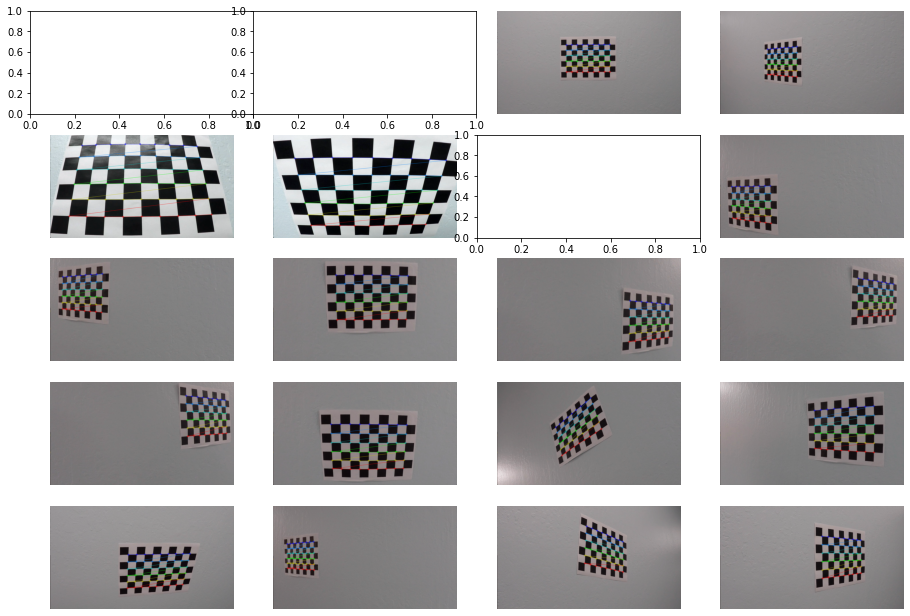

In [62]:
calibration_image_files = File.list_folder('./camera_cal/')

calibration_image_files = list(map(lambda x: './camera_cal/' + x, calibration_image_files))

camera = Camera()

calibration_result = camera.start_calibration(9, 6, calibration_image_files, CalibrationImageOutputRecorderUsingPyplot())

### Let's apply the found calibration matrix to the calibration images

I've added a new method in my `CvImage` class to undistort the image. We just need to pass the `calibration_result` to `undistort(calibration_result)` method.

Text(0.5, 1.0, 'Undistorted Image')

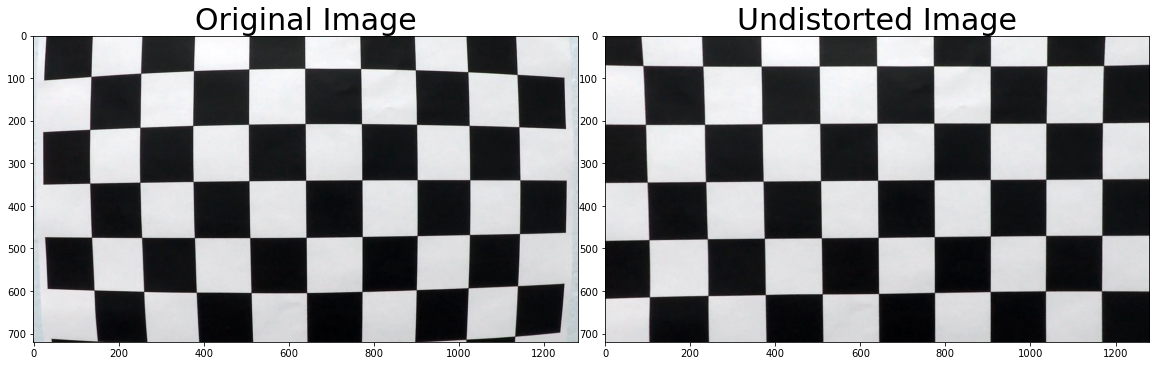

In [65]:
img = CvImage.load_from_file('./camera_cal/calibration1.jpg')
img_size = (img.image_data.shape[1], img.image_data.shape[0])

undistorted_image = img.undistort(calibration_result)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img.image_data)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image.image_data)
ax2.set_title('Undistorted Image', fontsize=30)

## Thresholded Binary Image

I will be using my own thresholded binary settings from my previous submission.

## Applying Perspective Transform 

We just need to apply perspective transform from the viewport area to top to bottom rectangle area.

## Identifying Lane Lines

## Radius of the Curvature

## Revert the Perspective Transform

## Processing the Project Video

## Processing the Challenge Video